# Tune Number of Topics for each model - LDA, NMF

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models.coherencemodel import CoherenceModel

import feather as ft

### Data Ingestion

In [7]:
#df = pd.read_pickle("../../data/final/final_dataset_7-20.pkl")

In [2]:
# data needed for coherence calculation

# import entire dataset
f = open('coherence_vars20.sav', 'rb')

[corpus, id2word, docs] = pickle.load(f)
f.close()

# corpus - word frequency in docs
# id2word - dictionary
# docs - df["final_frqwds_removed"]

In [3]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []

for abstract in docs:
    text.append(" ".join(abstract))

### Functions needed for all models

In [4]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [5]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def list_topics(model, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
        
    return topic_words

## LDA

In [6]:
# create document-term matrix

vectorizer = CountVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
doc_term_matrix = vectorizer.fit_transform(text)

In [7]:
# create model

num_topics = 5

t1 = time.time()
lda_model = LatentDirichletAllocation(n_components=num_topics, doc_topic_prior = 1/num_topics, 
                                      topic_word_prior=0.1, n_jobs=7, random_state = 257)
lda_model.fit_transform(doc_term_matrix)
t2 = time.time()
print(f"  Model time: {t2-t1}")

KeyboardInterrupt: 

In [8]:
# calculate topic coherence

# create list of topics
topics = list_topics(lda_model, vectorizer, top_n=10)

t1 = time.time()
cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=id2word, texts=docs, 
                    coherence='c_v', processes=10) #window_size=500 ) 
print(cm.get_coherence())
t2 = time.time()
print(f"  Coherence time: {t2-t1}")

0.6503025804114317
  Coherence time: 512.1495792865753


In [9]:
print_topics(lda_model, vectorizer, 10)


Topic 0:
('association', 28044.269447833365)
('cohort', 27846.03772960392)
('case', 25072.68178782223)
('population', 19162.900330439512)
('genetic', 14299.45668886145)
('controls', 9961.990512228133)
('collect', 7128.875819180357)
('wide', 4986.461345094191)
('african_americans', 4609.112945288659)
('individual', 4491.615494874667)

Topic 1:
('specimen', 13531.38033171047)
('laboratory', 13336.74000031109)
('assay', 9773.27385525988)
('expertise', 7298.816155390257)
('analytical', 5612.8398207326845)
('collection', 5526.333051213283)
('facility', 4703.83265918545)
('biological', 4345.487753480468)
('storage', 4179.950933663459)
('molecular', 3967.329083470286)

Topic 2:
('oxidative_stress', 16746.74702310819)
('ros', 14271.12068739558)
('macrophage', 8381.20098136607)
('redox', 7180.926566937739)
('antioxidant', 6883.768788444947)
('cell', 6275.212660444819)
('oxidative', 5299.845911489784)
('damage', 5195.565610288813)
('reactive_oxygen_species', 5057.931931752499)
('production', 49

**The code below is for when we want to tune our model by number of topics.  We look for the highest topic coherence value and choose that model as the best.**  

There is another metric available for LDA - perplexity.  We track this as well and look for the lowest perplexity.

In [7]:
# function adapted from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

def lda_metrics(doc_term_matrix, n_topics, vectorizer, corpus, id2word, docs, rand_start):
    """
    Compute perplexity and c_v topic coherence for various number of topics

    Parameters:
    ----------
    doc_term_matrix
    n_topics : list of number of topics

    Returns:
    -------
    coherence_values : c_v topic coherence values corresponding to the LDA model with respective number of topics
    """
    
    perplexity_values = []
    coherence_values = []
    
    i = rand_start 
    for num_topics in n_topics:
        
        # create model
        t1 = time.time()
        lda_model = LatentDirichletAllocation(n_components=num_topics, doc_topic_prior = 1/num_topics, 
                                              topic_word_prior=0.1, n_jobs=39, random_state = i)
        lda_model.fit_transform(doc_term_matrix)
        t2 = time.time()
        print(f"  Model time: {t2-t1}")
        
        # compute perplexity
        perplexity_values.append(lda_model.bound_)
        
        # create list of topics
        topics = list_topics(lda_model, vectorizer, top_n=10)
        
        # calculate coherence
        t1 = time.time()
        cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=id2word, texts=docs, 
                            coherence='c_v', processes=10) #window_size=500 ) 
        coherence_values.append(cm.get_coherence())
        t2 = time.time()
        print(f"  Coherence time: {t2-t1}")
        
        # output completion message
        i = i+1
        print('Number of topics =', num_topics, "complete.")

    return perplexity_values, coherence_values

In [ ]:
# code copied from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
# minor alterations made

n_topics = range(105,151,5) 
num_runs = 1

batch= 0

col_names = [f"iteration {i+batch}" for i in range(num_runs)]
lda_p = pd.DataFrame(index = n_topics, columns = col_names)
lda_c = pd.DataFrame(index = n_topics, columns = col_names)

for i in range(num_runs):
    
    print(f"Iteration {i}")
    
    # run models
    [p, c] = lda_metrics(doc_term_matrix=doc_term_matrix, n_topics=n_topics, vectorizer=vectorizer, 
                         corpus=corpus, id2word=id2word, docs=docs, rand_start = 248) #(i+batch)*len(n_topics)) -- 228
    
    # save results
    lda_p[f"iteration {i+batch}"] = p
    lda_c[f"iteration {i+batch}"] = c
       

Iteration 0
  Model time: 669.8582649230957
  Coherence time: 369.8085501194
Number of topics = 105 complete.
  Model time: 702.052579164505
  Coherence time: 406.5375988483429
Number of topics = 110 complete.
  Model time: 715.221480846405
  Coherence time: 391.1433913707733
Number of topics = 115 complete.
  Model time: 729.5471692085266
  Coherence time: 434.751793384552
Number of topics = 120 complete.
  Model time: 811.961040019989
  Coherence time: 481.04502058029175
Number of topics = 125 complete.
  Model time: 798.8298094272614
  Coherence time: 454.10427379608154
Number of topics = 130 complete.
  Model time: 867.9877436161041
  Coherence time: 484.00293493270874
Number of topics = 135 complete.
  Model time: 857.8530185222626
  Coherence time: 483.355672121048
Number of topics = 140 complete.


In [ ]:
# save results 

#lda_p.to_pickle("./lda_p2.pkl")
#lda_c.to_pickle("./lda_c2.pkl")

In [ ]:
lda_p

In [ ]:
lda_c

## NMF

In [6]:
# used for NMF and LSA

tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
tf_idf = tfidf_vectorizer.fit_transform(text)

In [11]:
# create model

num_topics = 20

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 14)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

  Model time: 219.06437516212463


In [8]:
# calculate topic coherence

# create list of topics
topics = list_topics(nmf_model, tfidf_vectorizer, top_n=10)

t1 = time.time()
cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=id2word, texts=docs, 
                    coherence='c_v', processes=7) #window_size=500 ) 
print(cm.get_coherence())
t2 = time.time()
print(f"  Coherence time: {t2-t1}")

0.6963439862404099
  Coherence time: 75.68849539756775


In [9]:
co_by_topic = cm.get_coherence_per_topic(with_std=True)

In [10]:
print_topics(nmf_model, tfidf_vectorizer, 10)


Topic 0:
('cell', 58.011941682182744)
('differentiation', 3.88692385827644)
('cellular', 2.9174239881030615)
('antigen', 2.705507032182264)
('culture', 2.514067856918683)
('proliferation', 2.3946849280871287)
('human', 2.276398008710594)
('line', 2.2207079533362446)
('cd4', 2.2075187338164013)
('epithelial', 2.0851557424260005)

Topic 1:
('student', 11.629737462241645)
('undergraduate', 2.7890710116853006)
('graduate', 2.688328766391275)
('college', 1.6299545900891006)
('faculty', 1.4363572334699553)
('course', 1.2990066405092004)
('summer', 1.2632290902909302)
('reu', 1.1804462348788285)
('career', 1.1766448261180815)
('opportunity', 0.9776525523786981)

Topic 2:
('cancer', 9.713117580562109)
('nci', 0.6291313590484898)
('pancreatic', 0.5281510686853984)
('member', 0.5211753372951083)
('ovarian', 0.49826534297306235)
('prevention', 0.48934800416059904)
('colorectal', 0.4210626947842294)
('colon', 0.35182170676628466)
('oncology', 0.3234102843462445)
('incidence', 0.27977704609286747)

In [11]:
co_by_topic

[(0.6150382097820386, 0.1086558703533419),
 (0.8817290979889683, 0.051302929556639086),
 (0.6622561981094672, 0.1515278366300957),
 (0.7709678592243688, 0.14832373284985878),
 (0.7132009374391264, 0.15407578168853772),
 (0.8073123073274656, 0.05661289133136901),
 (0.812359108178574, 0.06380685637390932),
 (0.7673700560198302, 0.08742006507096728),
 (0.8475813582171859, 0.06302112067072728),
 (0.634499174169507, 0.08634034274214428),
 (0.5863567637438459, 0.05883479316590134),
 (0.8817796944902507, 0.039093465170449836),
 (0.8471927520801552, 0.08284552627978757),
 (0.7512849837698888, 0.11029422530818353),
 (0.6048329611051201, 0.18283977847317262),
 (0.7627347084522874, 0.0983362255959998),
 (0.8740199216274414, 0.10347184805379857),
 (0.7460457732110158, 0.12369459188423905),
 (0.7362237506483408, 0.11014115173727365),
 (0.8474483423911605, 0.11402144878300476),
 (0.7008004119495654, 0.06759737023488488),
 (0.8706916341203168, 0.08910527482136273),
 (0.8075921710081682, 0.07507423080

**create output table for dashboard**

In [12]:
nmf_output = pd.DataFrame()
nmf_output["topic_words"] = topics
nmf_output["coherence_mean"] = [c[0] for c in co_by_topic]
nmf_output["coherence_stdev"] = [c[1] for c in co_by_topic]

In [13]:
doc_topic_df = pd.DataFrame(data=doc_topic.copy())
nmf_output["avg_weight_in_corpus"] = doc_topic_df.mean(axis=0)
nmf_output["med_weight_in_corpus"] = doc_topic_df.median(axis=0)

In [14]:
# create a column for the number of documents that contain a topic

doc_topic_bool = pd.DataFrame(data=doc_topic.copy())
doc_topic_bool[doc_topic_bool > 0] = 1 

In [15]:
doc_topic_bool.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [16]:
nmf_output["num_docs_containing_topic"] = doc_topic_bool.sum(axis=0)
nmf_output["percent_docs_containing_topic"] = 100*(nmf_output["num_docs_containing_topic"]/doc_topic.shape[0])

In [17]:
# find the dominant topic per document

max_topic = doc_topic_df.idxmax(axis=1)

In [18]:
nmf_output["num_times_max_topic"] = max_topic.value_counts()
nmf_output["percent_times_max_topic"] = 100*(nmf_output["num_times_max_topic"]/doc_topic.shape[0])

In [19]:
nmf_output

,topic_words,coherence_mean,coherence_stdev,avg_weight_in_corpus,med_weight_in_corpus,num_docs_containing_topic,percent_docs_containing_topic,num_times_max_topic,percent_times_max_topic
0,"[cell, differentiation, cellular, antigen, cul...",0.615038,0.108656,0.000502,1.968816e-07,346034.0,50.090762,767,0.111028
1,"[student, undergraduate, graduate, college, fa...",0.881729,0.051303,0.001211,0.000000e+00,217644.0,31.505441,17352,2.511819
2,"[cancer, nci, pancreatic, member, ovarian, pre...",0.662256,0.151528,0.001800,0.000000e+00,251421.0,36.394891,24706,3.576361
3,"[hiv, aids, infect, prevention, cfar, antiretr...",0.770968,0.148324,0.000582,0.000000e+00,216121.0,31.284977,9563,1.384309
4,"[infection, infect, immune, viral, hpv, hcv, p...",0.713201,0.154076,0.001173,0.000000e+00,236715.0,34.266098,15936,2.306844
...,...,...,...,...,...,...,...,...,...
70,"[muscle, skeletal_muscle, exercise, motor, fib...",0.659376,0.158322,0.000869,0.000000e+00,214886.0,31.106202,9792,1.417458
71,"[receptor, ligand, bind, activation, gpcr, ago...",0.690983,0.146998,0.001754,0.000000e+00,277181.0,40.123825,25986,3.761649
72,"[pd, parkinson, motor, lrrk2, da, dopamine, do...",0.759732,0.208970,0.000685,0.000000e+00,207201.0,29.993747,5399,0.781542
73,"[facility, user, equipment, instrument, labora...",0.746481,0.105164,0.001722,0.000000e+00,265271.0,38.399772,26922,3.897142


In [20]:
nmf_output.to_pickle("./nmf_results.pkl")

In [27]:
max_topic.value_counts()

9     30280
73    26922
71    25986
2     24706
74    23595
      ...  
22     1997
25     1369
27     1076
29     1047
0       767
Length: 75, dtype: int64

**create a distribution of the number of topics per document**

In [21]:
topics_per_doc = doc_topic_bool.sum(axis=1).astype(int)

In [22]:
topics_per_doc.mean()

26.288126760604158

In [23]:
topics_per_doc.median()

26.0

In [24]:
temp = topics_per_doc.value_counts()
temp

23    28711
24    28287
25    28178
22    27859
26    27725
      ...  
64        9
65        5
66        4
67        2
69        1
Length: 69, dtype: int64

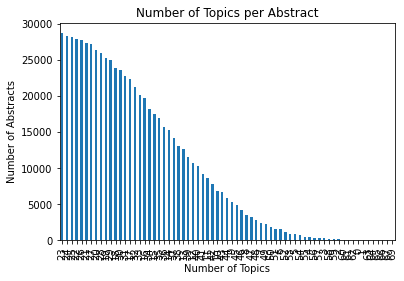

In [25]:
temp.plot(kind="bar");
plt.title("Number of Topics per Abstract")
plt.xlabel("Number of Topics")
plt.ylabel("Number of Abstracts");

In [26]:
topics_per_doc.to_pickle("./topics_per_doc.pkl")

**The code below is for when we want to tune our model by number of topics.  We look for the highest topic coherence value and choose that model as the best.**

In [ ]:
# function adapted from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

def nmf_metrics(doc_term_matrix, n_topics, vectorizer, corpus, id2word, docs, rand_start):
    """
    Compute c_v topic coherence for various number of topics

    Parameters:
    ----------
    tf_idf
    n_topics : list of number of topics

    Returns:
    -------
    coherence_values : c_v topic coherence values corresponding to the NMF model with respective number of topics
    """
    
    coherence_values = []
    
    i = rand_start
    for num_topics in n_topics:

        # create model
        t1 = time.time()
        nmf_model = NMF(n_components=num_topics, random_state = i)
        nmf_model.fit_transform(doc_term_matrix)
        t2 = time.time()
        print(f"  Model time: {t2-t1}")
        
        # create list of topics
        topics = list_topics(nmf_model, vectorizer, top_n=10)
        
        # calculate coherence
        t1 = time.time()
        cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=id2word, texts=docs, 
                            coherence='c_v', processes=10) #window_size=500 ) 
        coherence_values.append(cm.get_coherence())
        t2 = time.time()
        print(f"  Coherence time: {t2-t1}")
        
        # output completion message
        i = i+1
        print('Number of topics =', num_topics, "complete.")

    return coherence_values

In [ ]:
# code copied from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
# minor alterations made

n_topics = [16] #range(4,101,4) 
num_runs = 1

batch = 0

col_names = [f"iteration {i+batch}" for i in range(num_runs)]
nmf_c = pd.DataFrame(index = n_topics, columns = col_names)

for i in range(num_runs):
    
    print(f"Iteration {i}")
    
    # run models
    c = nmf_metrics(doc_term_matrix=tf_idf, n_topics=n_topics, vectorizer=tfidf_vectorizer, 
                         corpus=corpus, id2word=id2word, docs=docs, rand_start = (i+batch)*len(n_topics))
    
    # save results
    nmf_c[f"iteration {i+batch}"] = c
       

In [ ]:
# save results 

#nmf_c.to_pickle("./nmf_c.pkl")